In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader, Dataset

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from models import *

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import dataloaders.nih_xray8 as nih_xray8
import dataloaders.chexpert as chexpert
import dataloaders.kaggle_rsna as kaggle_rsna

For each saved model and for each dataset, this notebook will test the model with the given dataset. Using the test split.

Make sure to use the same split ratio and the same seed used in the training notebook!

In [ ]:
# Configuration
project_working_dir = '/projects/resnet50'
batch_size = 64
n_workers = 4
model1_file = "resnet_chest.pth"
model2_file = "resnet_chex.pth"
model3_file = "resnet_rsna.pth"
model4_file = "resnet_nih_cxr.pth"
resnet_model = PneumoniaResnet()

# Always use the same values as the training notebook
# otherwise it's going to test on the same samples it trained on, which is not a good idea and will falsely inflate the results
# if ratio is 0.8, we are going to test using 20% of the data
# also, make sure to use always the same seed
random_seed = 42
split_ratio = 0.8

# Dataset paths
DATASET1_PATH = '/bigdata/chest_xray-3'
DATASET2_PATH = '/bigdata/CheXpert-v1.0-small'
DATASET3_PATH = '/bigdata/kaggle-rsna'

torch.manual_seed(random_seed)
os.chdir(project_working_dir)

/projects/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/projects/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Load the datasets

Data will be loaded, splitted in train / test and the following transformations will be applied:

1. Resize and crop to 224x224 as many images are of different sizes
2. Convert images into PyTorch tensors
3. Normalize images

In [ ]:
data1_dir = DATASET1_PATH
dataset1 = ImageFolder(data1_dir, 
                      transform=tt.Compose([tt.Resize((224, 224)),
                                            tt.ToTensor(),
                                            tt.Normalize(mean=0.482, std=0.236, inplace=True) # dataset1 mean and std
                                           ]))

In [ ]:
data2_dir = DATASET2_PATH

transform2=tt.Compose([ tt.Resize((224, 224)),
                        tt.ToTensor(),
                        tt.Normalize(mean=0.5017, std=0.2905, inplace=True) # dataset2 mean and std
                        ])

dataset2 = chexpert.CheXDataset(data2_dir, [transform2])

Loading dataset...


In [ ]:
data3_dir = DATASET3_PATH

transform3=tt.Compose([ tt.ToTensor(),
                        tt.Normalize(mean=0.4841, std=0.2428, inplace=True) # dataset3 mean and std
                        ])

dataset3 = kaggle_rsna.RSNADataset(data3_dir, [transform3])

Loading dataset...


# Train / test split

in order to use only the test split, we repeat the same split used in training, with the same ratio and the same seed

In [7]:
train_size_1 = round(len(dataset1)*split_ratio)
test_size_1 = len(dataset1) - train_size_1

train_size_2 = round(len(dataset2)*split_ratio)
test_size_2 = len(dataset2) - train_size_2

train_size_3 = round(len(dataset3)*split_ratio)
test_size_3 = len(dataset3) - train_size_3

_, test_ds1 = random_split(dataset1, [train_size_1, test_size_1])
_, test_ds2 = random_split(dataset2, [train_size_2, test_size_2])
_, test_ds3 = random_split(dataset3, [train_size_3, test_size_3])

test_dl1 = DataLoader(test_ds1, batch_size, num_workers=n_workers, pin_memory=True)
test_dl2 = DataLoader(test_ds2, batch_size, num_workers=n_workers, pin_memory=True)
test_dl3 = DataLoader(test_ds3, batch_size, num_workers=n_workers, pin_memory=True)

Helper functions, better described in the training notebook

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print("Running on:", device)

model = to_device(resnet_model, device)

Running on: cuda


In [ ]:
# Function to load the pre-trained weights

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

In [ ]:
# Function to predict on the test set

@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels'], results['test_out']

Helper functions to compute metrics and plot them

In [11]:
def compute_roc(outs, labels):
    scores = F.softmax(torch.tensor(outs), dim=1)[:, 1]
    scores = scores.detach().numpy()
        
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)
    best_threshold = thresholds[np.argmin(distances)]
    preds = [1 if score > best_threshold else 0 for score in scores]

    return fpr, tpr, best_threshold, preds, roc_auc_score(labels, scores)

def plot_roc(fpr, tpr, best_threshold, auroc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auroc})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

def plot_cm(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.xlabel('Predicted Label',fontsize=18)
    plt.ylabel('True Label',fontsize=18)
    plt.show()

def get_performance_metrics(cm, preds, labels):
    tn, fp, fn, tp = cm.ravel()

    accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))

    print("Accuracy of the model is {:.3f}".format(accuracy))
    print("Recall of the model is {:.3f}".format(recall))
    print("Precision of the model is {:.3f}".format(precision))
    print("F1 Score of the model is {:.3f}".format(f1))
    return accuracy, recall, precision, f1

### Model pre-trained on the "Chest-Xray Images" dataset

In [12]:
model = load_checkpoint(model1_file).to(device)

/tmp/ipykernel_90549/1638630175.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


#### Test on "Chest-Xray Images" dataset

In [13]:
test_dl = DeviceDataLoader(test_dl1, device)
preds, labels, outs = test_predict(model, test_dl)

test_loss: 0.0952, test_acc: 0.9676


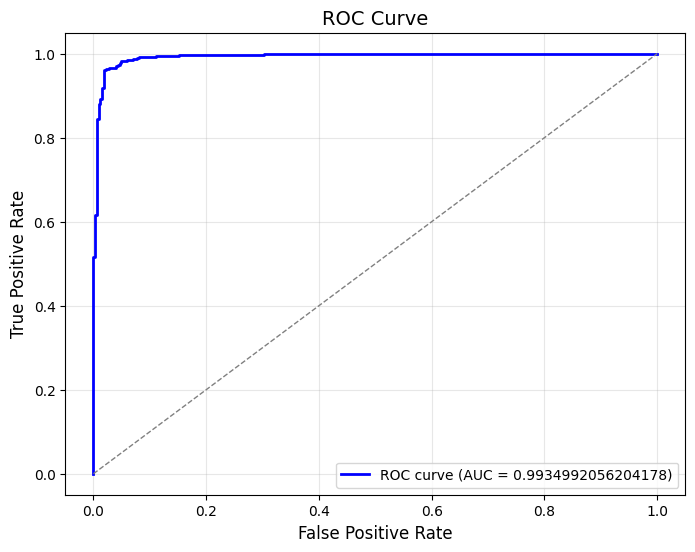

In [14]:
fpr, tpr, best_threshold, preds, auroc_1_1 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_1_1)

<Figure size 640x480 with 0 Axes>

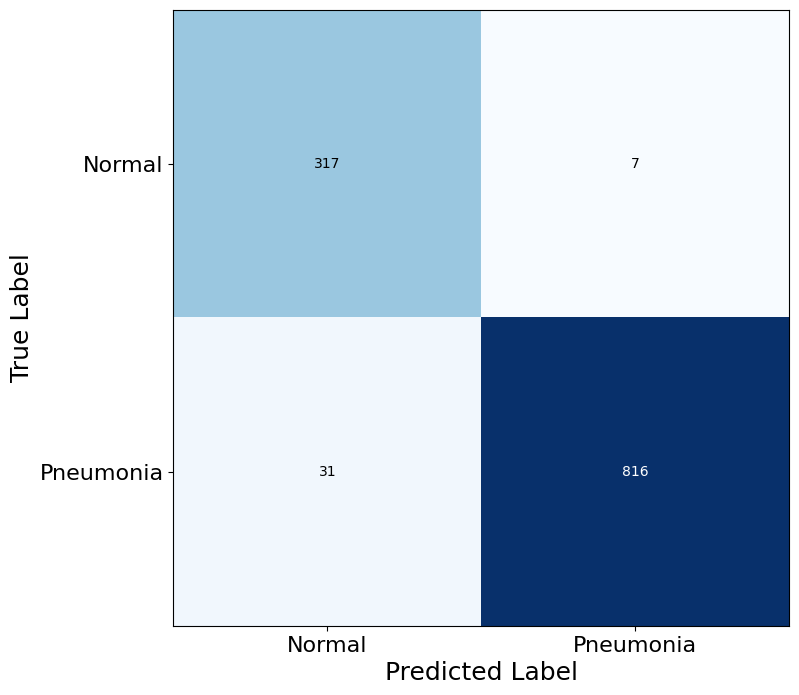

Accuracy of the model is 0.968
Recall of the model is 0.963
Precision of the model is 0.991
F1 Score of the model is 0.977


In [15]:
plot_cm(labels, preds)
accuracy_1_1, recall_1_1, precision_1_1, f1_1_1 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

#### Test on "CheXpert" dataset

In [16]:
test_dl = DeviceDataLoader(test_dl2, device)
preds, labels, outs = test_predict(model, test_dl)

test_loss: 2.5830, test_acc: 0.5173


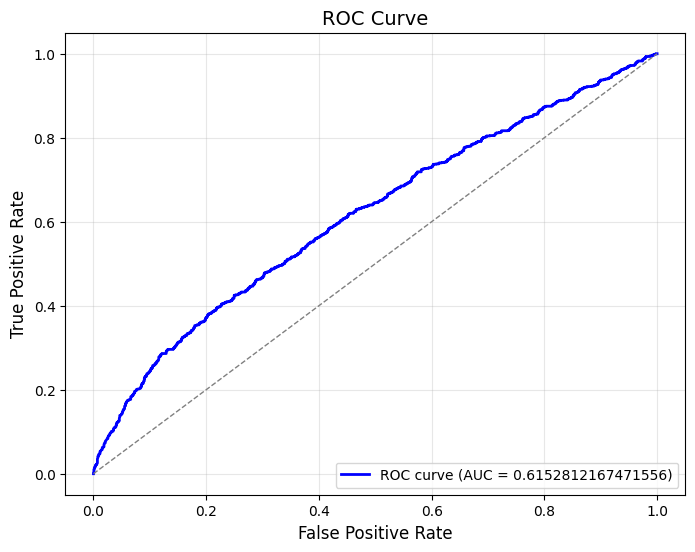

In [17]:
fpr, tpr, best_threshold, preds, auroc_1_2 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_1_2)

<Figure size 640x480 with 0 Axes>

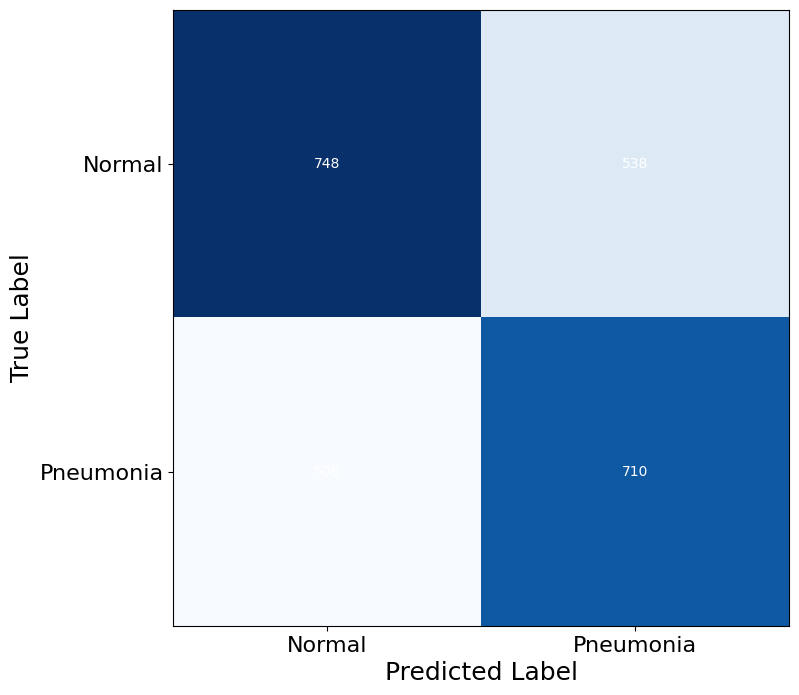

Accuracy of the model is 0.583
Recall of the model is 0.584
Precision of the model is 0.569
F1 Score of the model is 0.576


In [18]:
plot_cm(labels, preds)
accuracy_1_2, recall_1_2, precision_1_2, f1_1_2 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

#### Test on "RSNA" dataset

In [19]:
test_dl = DeviceDataLoader(test_dl3, device)
preds, labels, outs = test_predict(model, test_dl)

test_loss: 3.1955, test_acc: 0.4777


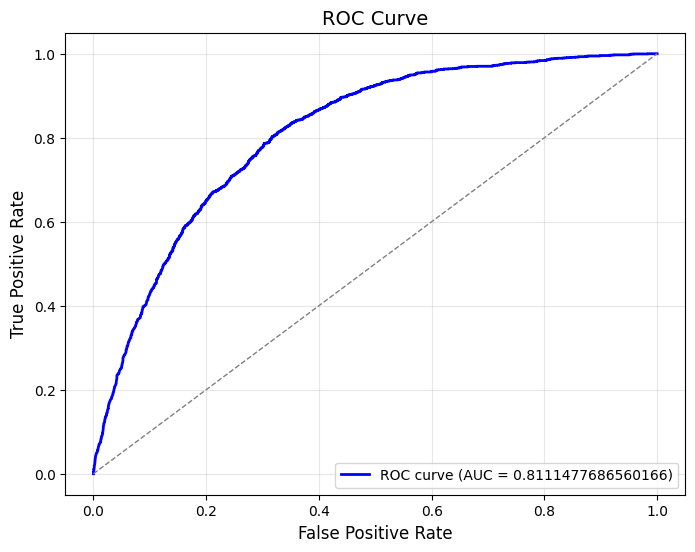

In [20]:
fpr, tpr, best_threshold, preds, auroc_1_3 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_1_3)

<Figure size 640x480 with 0 Axes>

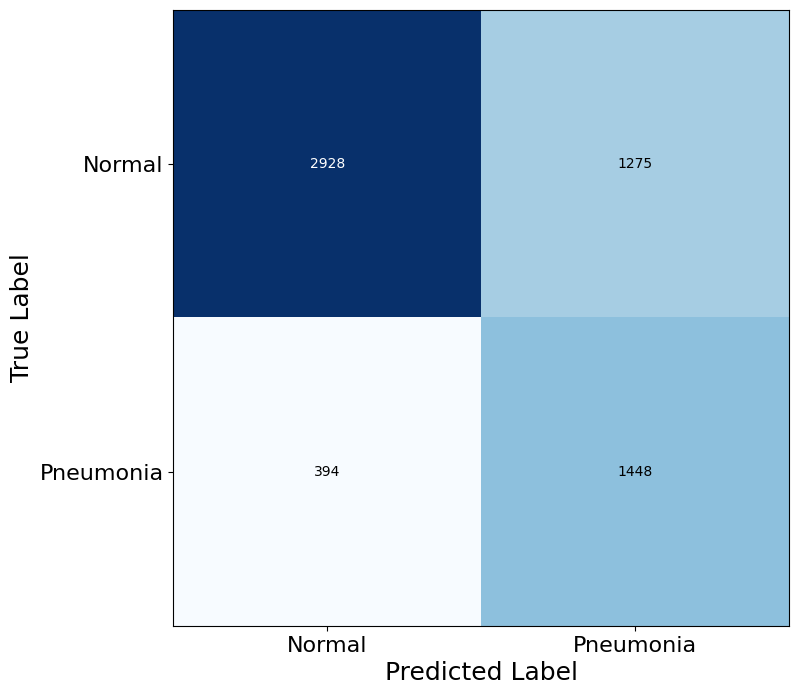

Accuracy of the model is 0.724
Recall of the model is 0.786
Precision of the model is 0.532
F1 Score of the model is 0.634


In [21]:
plot_cm(labels, preds)
accuracy_1_3, recall_1_3, precision_1_3, f1_1_3 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

### Model pre-trained on the "CheXpert" dataset

In [22]:
model = load_checkpoint(model2_file).to(device)

/tmp/ipykernel_90549/1638630175.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


#### Test on "Chest-Xray Images" dataset

In [23]:
test_dl = DeviceDataLoader(test_dl1, device)
preds, labels, outs = test_predict(model, test_dl)

test_loss: 0.5329, test_acc: 0.7332


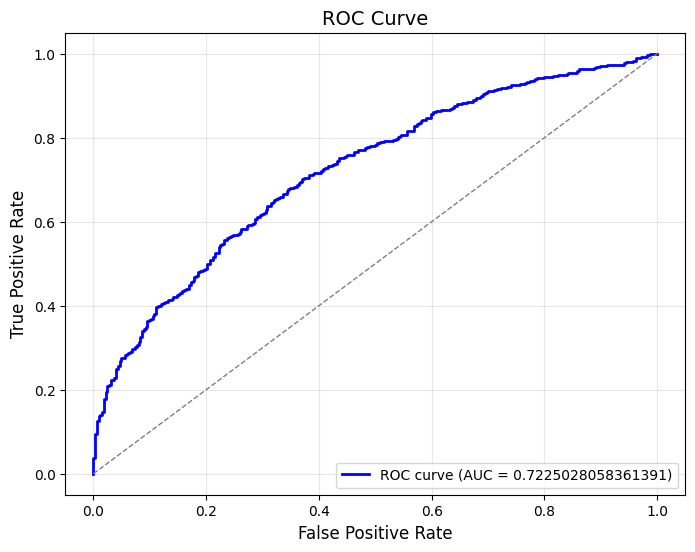

In [24]:
fpr, tpr, best_threshold, preds, auroc_2_1 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_2_1)

<Figure size 640x480 with 0 Axes>

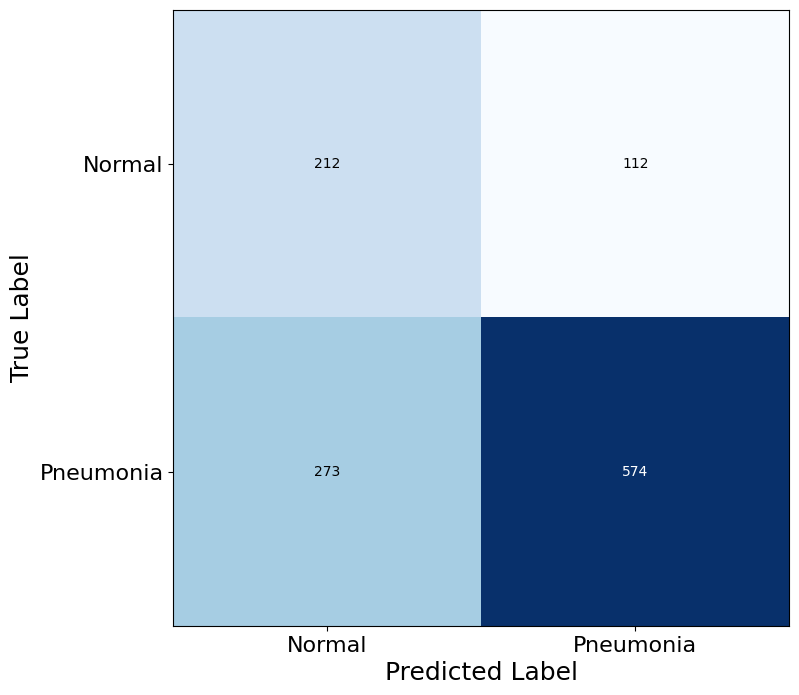

Accuracy of the model is 0.671
Recall of the model is 0.678
Precision of the model is 0.837
F1 Score of the model is 0.749


In [25]:
plot_cm(labels, preds)
accuracy_2_1, recall_2_1, precision_2_1, f1_2_1 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

#### Test on "CheXpert" dataset

In [26]:
test_dl = DeviceDataLoader(test_dl2, device)
preds, labels, outs = test_predict(model, test_dl)

test_loss: 0.4606, test_acc: 0.7910


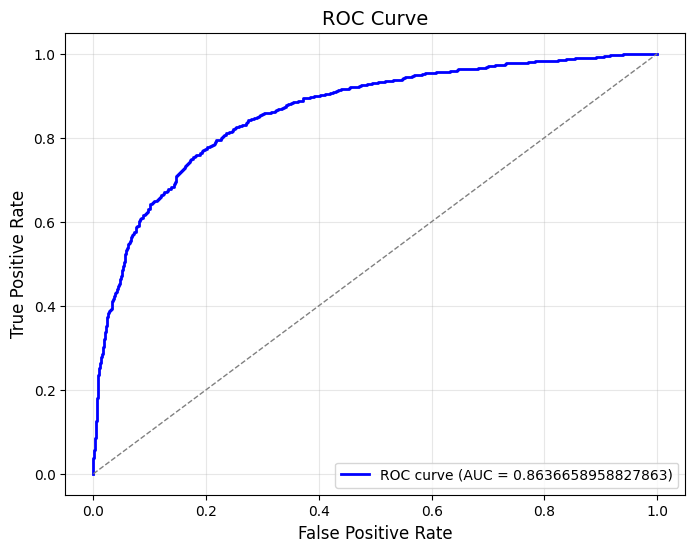

In [27]:
fpr, tpr, best_threshold, preds, auroc_2_2 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_2_2)

<Figure size 640x480 with 0 Axes>

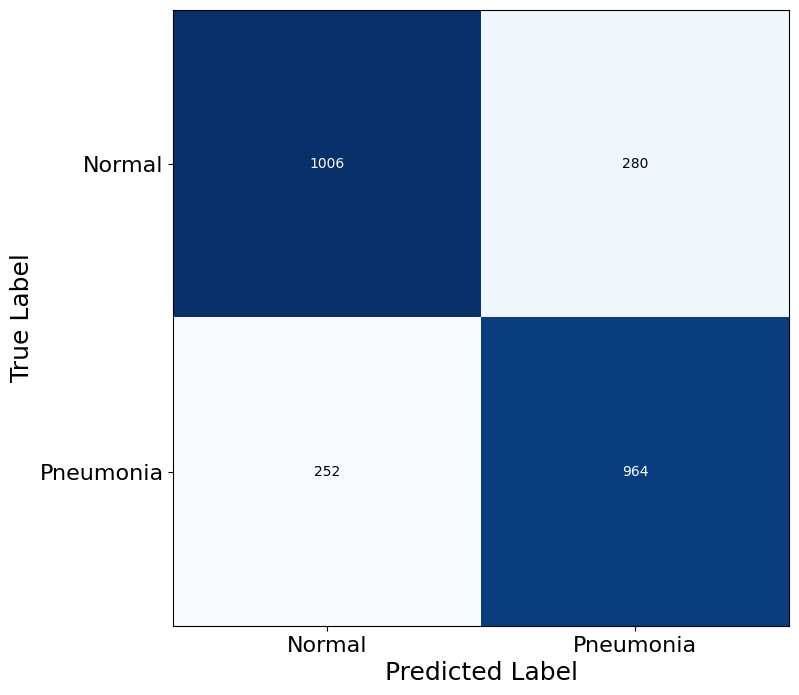

Accuracy of the model is 0.787
Recall of the model is 0.793
Precision of the model is 0.775
F1 Score of the model is 0.784


In [28]:
plot_cm(labels, preds)
accuracy_2_2, recall_2_2, precision_2_2, f1_2_2 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

#### Test on "RSNA" dataset

In [29]:
test_dl = DeviceDataLoader(test_dl3, device)
preds, labels, outs = test_predict(model, test_dl)

test_loss: 0.6972, test_acc: 0.6444


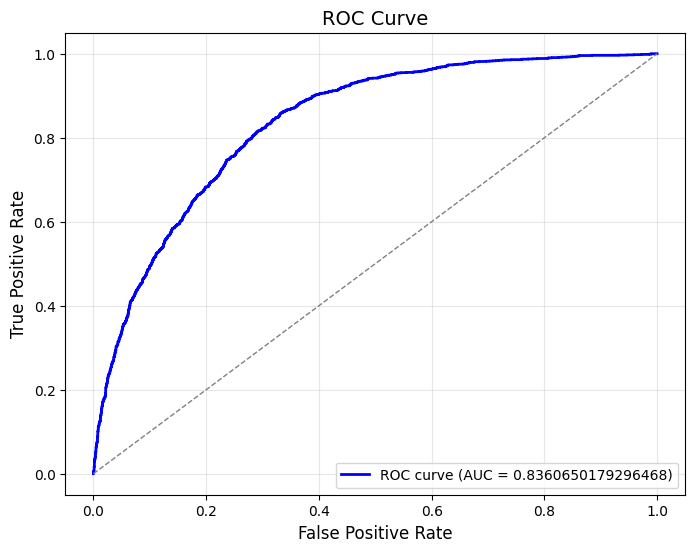

In [30]:
fpr, tpr, best_threshold, preds, auroc_2_3 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_2_3)

<Figure size 640x480 with 0 Axes>

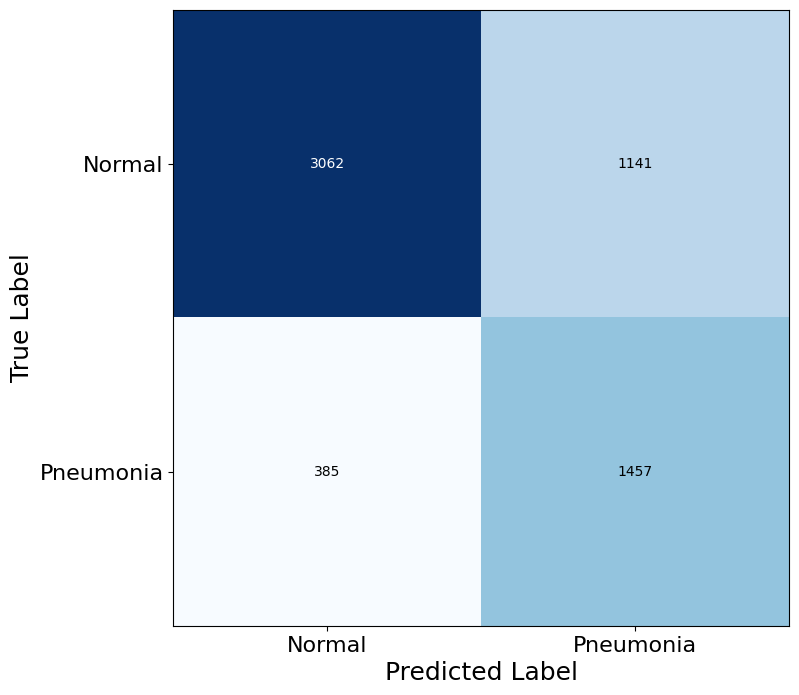

Accuracy of the model is 0.748
Recall of the model is 0.791
Precision of the model is 0.561
F1 Score of the model is 0.656


In [31]:
plot_cm(labels, preds)
accuracy_2_3, recall_2_3, precision_2_3, f1_2_3 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

### Model pre-trained on the "RSNA" dataset

In [32]:
model = load_checkpoint(model3_file).to(device)

/tmp/ipykernel_90549/1638630175.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


#### Test on "Chest-Xray Images" dataset

In [33]:
test_dl = DeviceDataLoader(test_dl1, device)
preds, labels, outs = test_predict(model, test_dl)

test_loss: 0.6561, test_acc: 0.6242


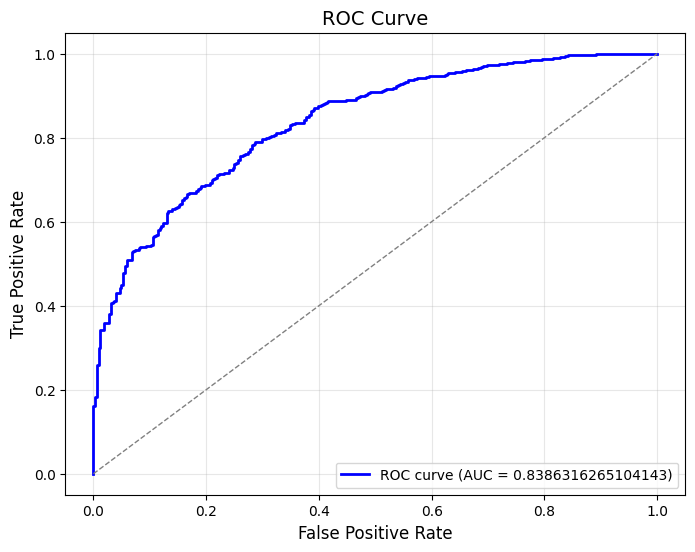

In [34]:
fpr, tpr, best_threshold, preds, auroc_3_1 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_3_1)

<Figure size 640x480 with 0 Axes>

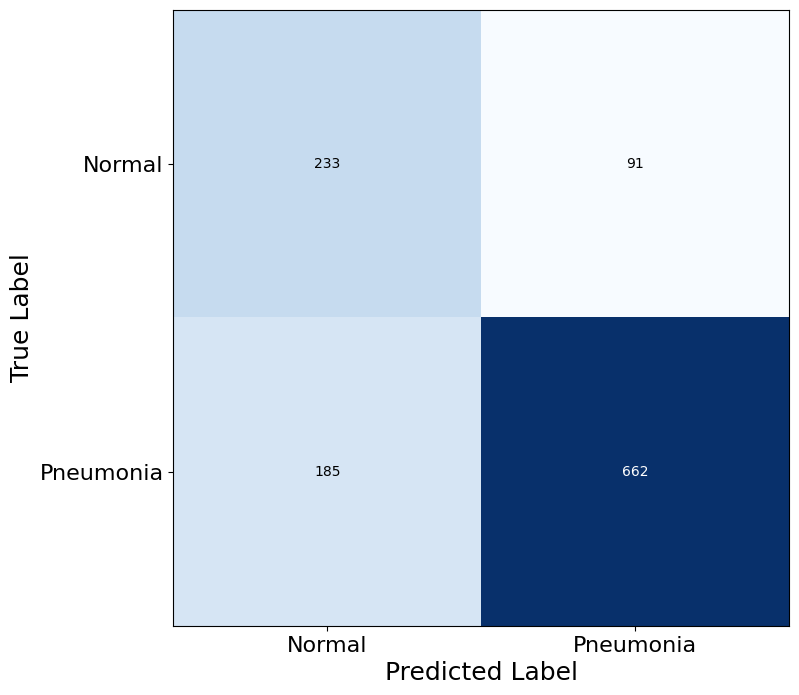

Accuracy of the model is 0.764
Recall of the model is 0.782
Precision of the model is 0.879
F1 Score of the model is 0.828


In [35]:
plot_cm(labels, preds)
accuracy_3_1, recall_3_1, precision_3_1, f1_3_1 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

#### Test on "CheXpert" dataset

In [36]:
test_dl = DeviceDataLoader(test_dl2, device)
preds, labels, outs = test_predict(model, test_dl)

test_loss: 0.7193, test_acc: 0.6733


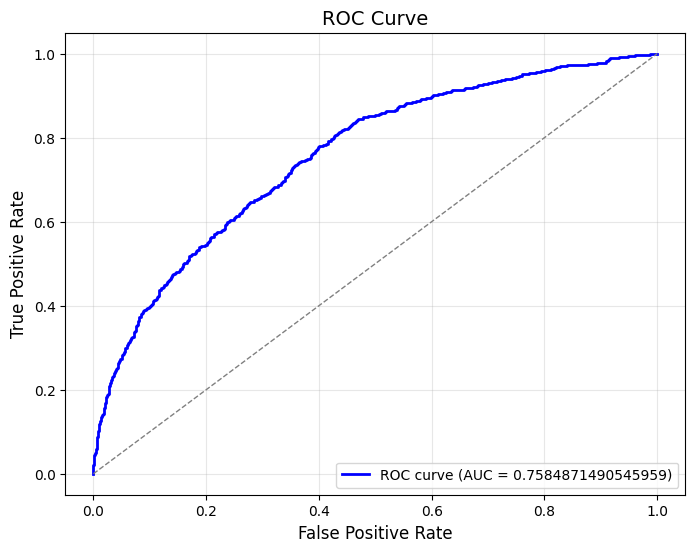

In [37]:
fpr, tpr, best_threshold, preds, auroc_3_2 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_3_2)

<Figure size 640x480 with 0 Axes>

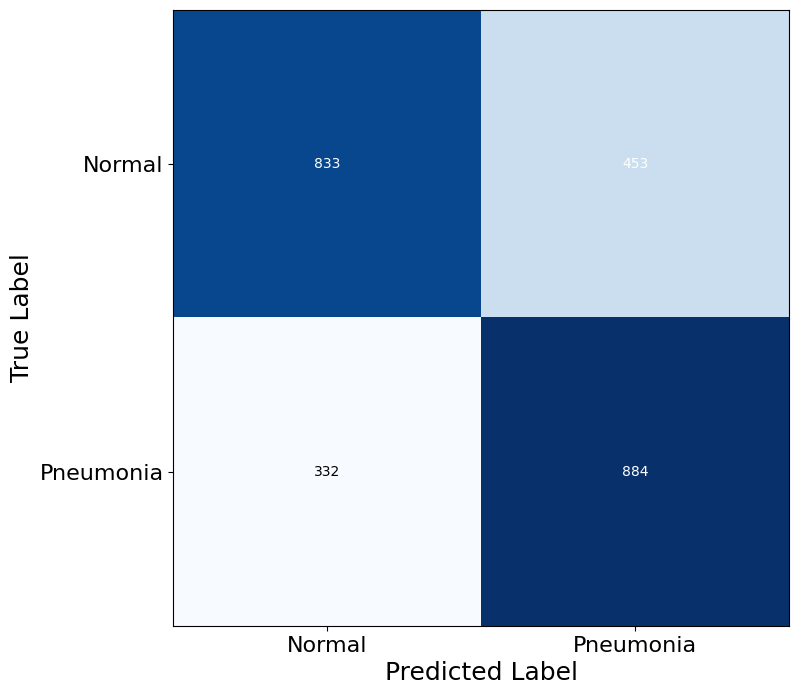

Accuracy of the model is 0.686
Recall of the model is 0.727
Precision of the model is 0.661
F1 Score of the model is 0.693


In [38]:
plot_cm(labels, preds)
accuracy_3_2, recall_3_2, precision_3_2, f1_3_2 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

#### Test on "RSNA" dataset

In [39]:
test_dl = DeviceDataLoader(test_dl3, device)
preds, labels, outs = test_predict(model, test_dl)

test_loss: 0.3520, test_acc: 0.8248


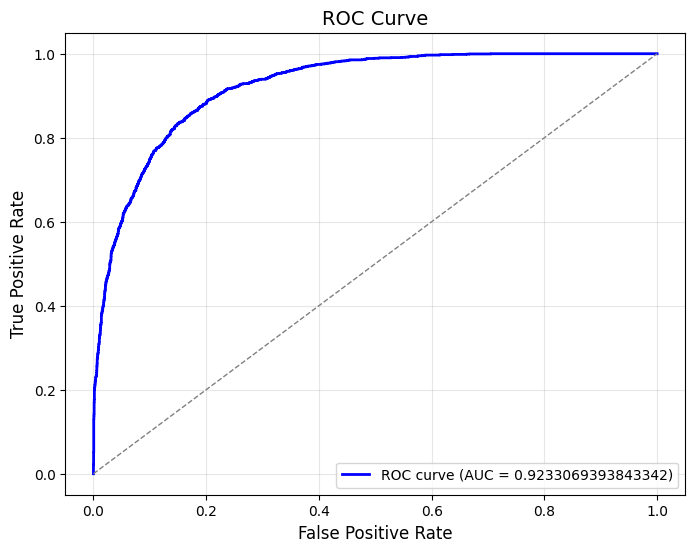

In [40]:
fpr, tpr, best_threshold, preds, auroc_3_3 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_3_3)

<Figure size 640x480 with 0 Axes>

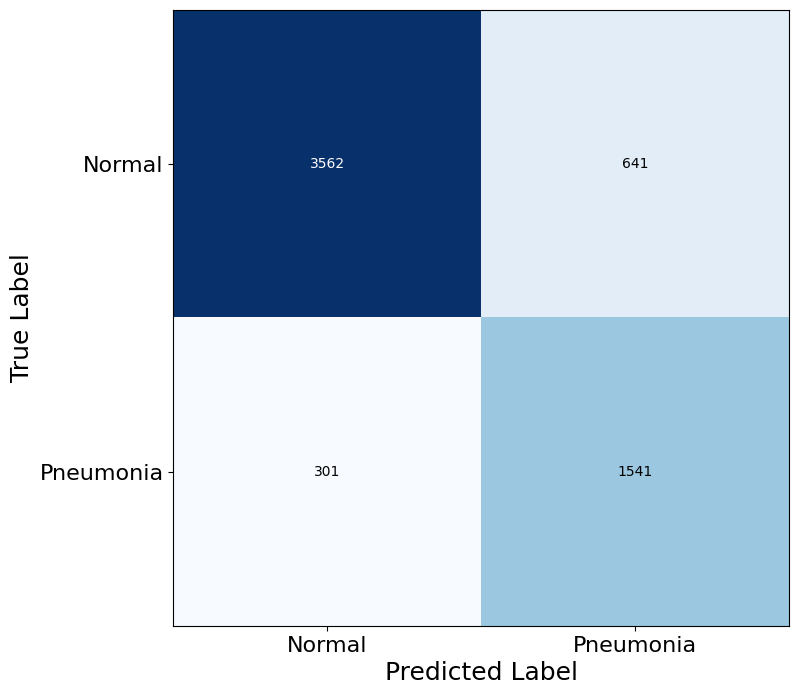

Accuracy of the model is 0.844
Recall of the model is 0.837
Precision of the model is 0.706
F1 Score of the model is 0.766


In [41]:
plot_cm(labels, preds)
accuracy_3_3, recall_3_3, precision_3_3, f1_3_3 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

# Plot the heatmaps

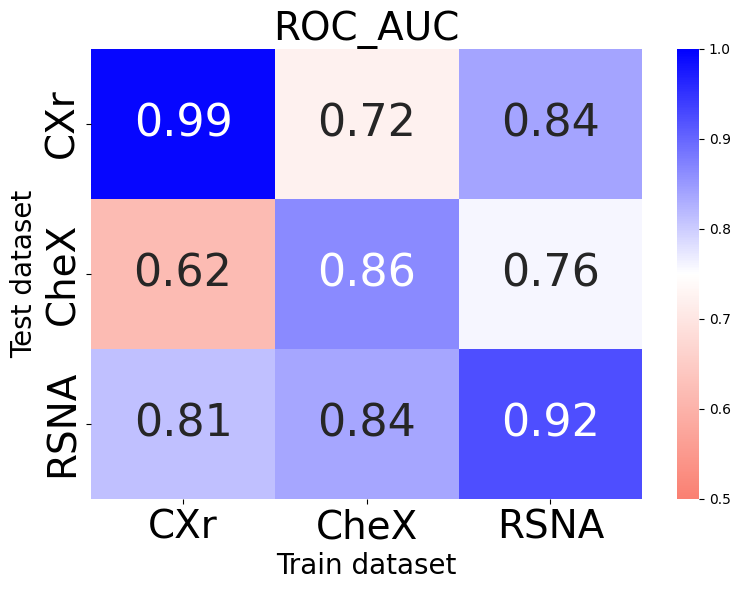

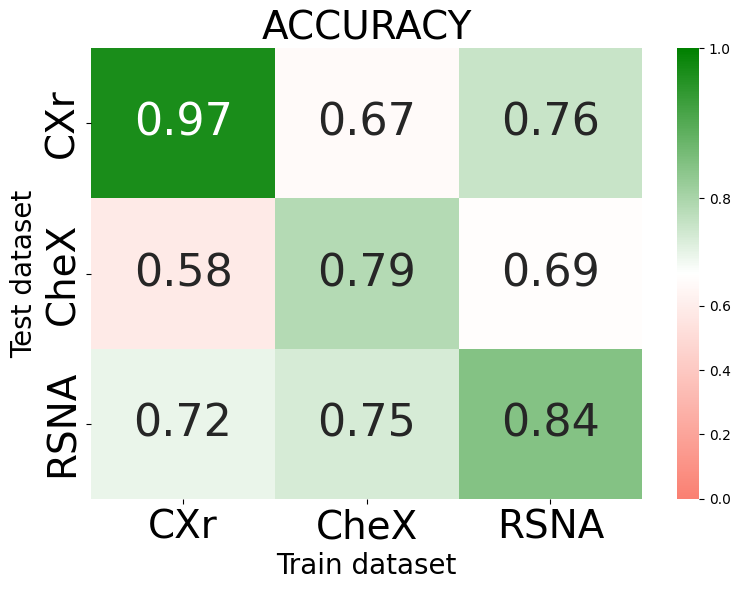

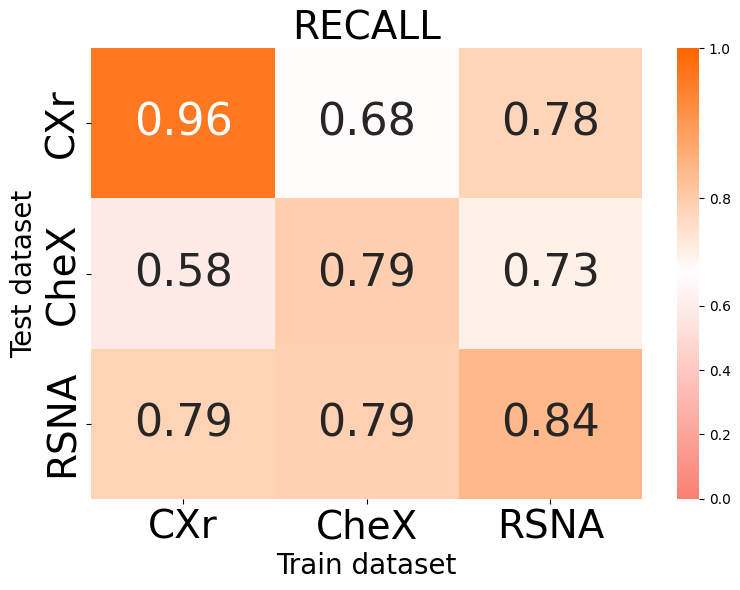

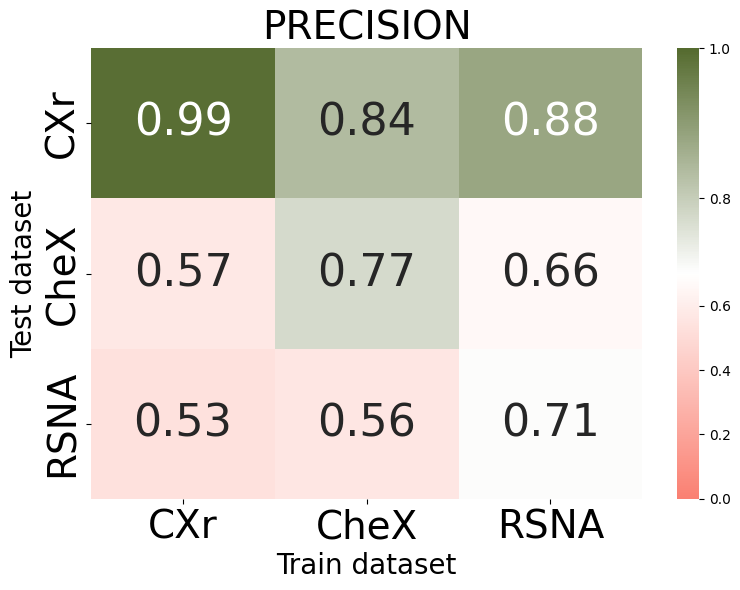

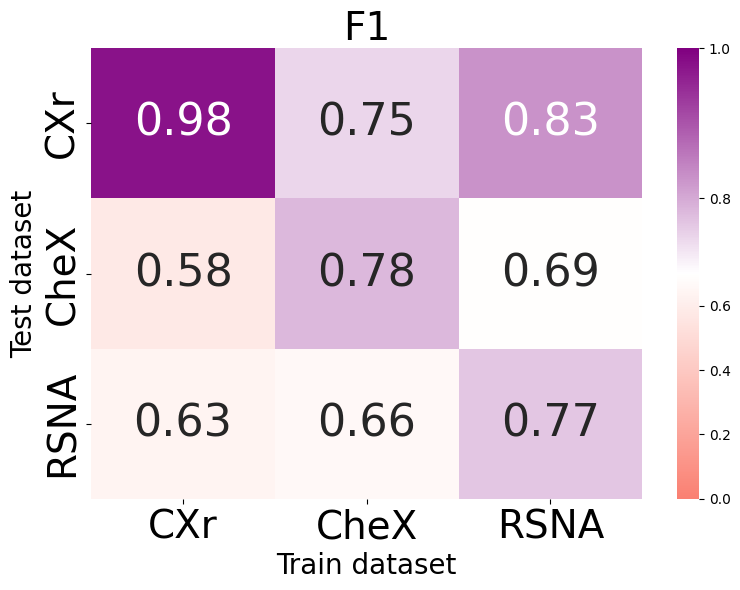

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Define unique colormaps for each metric
blue = LinearSegmentedColormap.from_list("a", ["salmon", "#ffffff", "#0000ff"])
green = LinearSegmentedColormap.from_list("b", ["salmon", "#ffffff", "#008000"])
green_2 = LinearSegmentedColormap.from_list("c", ["salmon", "#ffffff", "#556b2f"])
orange = LinearSegmentedColormap.from_list("d", ["salmon", "#ffffff", "#ff6500"])
purple = LinearSegmentedColormap.from_list("e", ["salmon", "#ffffff", "#800080"])

metric_colormaps = {
    "roc_auc": blue,
    "f1": purple,
    "precision": green_2,
    "recall": orange,
    "accuracy": green
}

# Define your metrics and data as numpy arrays
metrics_data = {
    "roc_auc": np.array([
        [auroc_1_1, auroc_1_2, auroc_1_3],
        [auroc_2_1, auroc_2_2, auroc_2_3],
        [auroc_3_1, auroc_3_2, auroc_3_3]
    ]),
    "accuracy": np.array([
        [accuracy_1_1, accuracy_1_2, accuracy_1_3],
        [accuracy_2_1, accuracy_2_2, accuracy_2_3],
        [accuracy_3_1, accuracy_3_2, accuracy_3_3]
    ]),
    "recall": np.array([
        [recall_1_1, recall_1_2, recall_1_3],
        [recall_2_1, recall_2_2, recall_2_3],
        [recall_3_1, recall_3_2, recall_3_3]
    ]),
    "precision": np.array([
        [precision_1_1, precision_1_2, precision_1_3],
        [precision_2_1, precision_2_2, precision_2_3],
        [precision_3_1, precision_3_2, precision_3_3]
    ]),
    "f1": np.array([
        [f1_1_1, f1_1_2, f1_1_3],
        [f1_2_1, f1_2_2, f1_2_3],
        [f1_3_1, f1_3_2, f1_3_3]
    ])
}

def plot_model_heatmaps_with_colors(dataset_names, metrics_data, metric_colormaps={}):
    metrics = list(metrics_data.keys())

    for metric_name in metrics:
        metric_scores = metrics_data[metric_name].transpose()

        # Set vmin and center based on the metric
        if metric_name == 'roc_auc':
            vcenter = 0.75
            vmin = 0.5
        else:
            vcenter = 0.7
            vmin = 0

        divnorm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=1)

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            metric_scores,
            annot=True,
            xticklabels=dataset_names,
            yticklabels=dataset_names,
            cmap=metric_colormaps.get(metric_name, 'coolwarm'),  # Use a default colormap if not specified
            cbar_kws={'label': ""},
            norm=divnorm,
            annot_kws={"size": 32},  # Increase annotation text size
        )
        plt.title(f"{metric_name.upper()}", fontsize=28)  # Increase title font size
        plt.xlabel("Train dataset", fontsize=20)  # Increase x-axis label font size
        plt.ylabel("Test dataset", fontsize=20)  # Increase y-axis label font size
        plt.xticks(fontsize=28)  # Increase x-axis ticks font size
        plt.yticks(fontsize=28)  # Increase y-axis ticks font size
        plt.tight_layout()
        plt.show()


# Dataset names
dataset_names = ["CXr", "CheX", "RSNA"]

# Generate heatmaps
plot_model_heatmaps_with_colors(dataset_names, metrics_data, metric_colormaps)

# Plot the histogram of averages

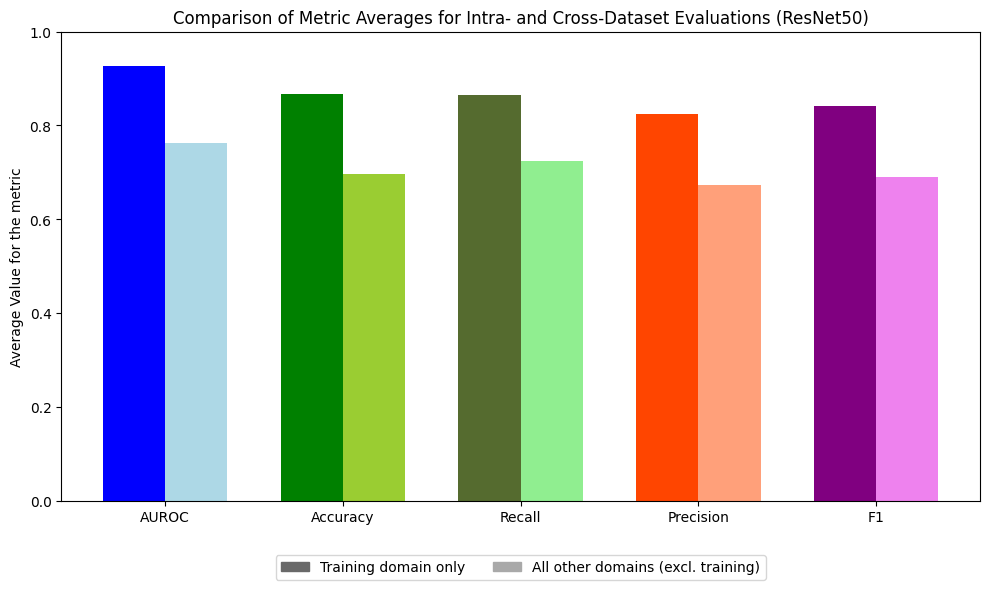

In [ ]:
# Load the metrics
auroc = np.array([[auroc_1_1, auroc_1_2, auroc_1_3],
                  [auroc_2_1, auroc_2_2, auroc_2_3],
                  [auroc_3_1, auroc_3_2, auroc_3_3]])

accuracy = np.array([[accuracy_1_1, accuracy_1_2, accuracy_1_3],
                     [accuracy_2_1, accuracy_2_2, accuracy_2_3],
                     [accuracy_3_1, accuracy_3_2, accuracy_3_3]])

recall = np.array([[recall_1_1, recall_1_2, recall_1_3],
                   [recall_2_1, recall_2_2, recall_2_3],
                   [recall_3_1, recall_3_2, recall_3_3]])

precision = np.array([[precision_1_1, precision_1_2, precision_1_3],
                      [precision_2_1, precision_2_2, precision_2_3],
                      [precision_3_1, precision_3_2, precision_3_3]])

f1 = np.array([[f1_1_1, f1_1_2, f1_1_3],
               [f1_2_1, f1_2_2, f1_2_3],
               [f1_3_1, f1_3_2, f1_3_3]])

# Compute the means for the same and different datasets
def calculate_means(metric_data):
    same_dataset = np.diagonal(metric_data)
    different_dataset = metric_data[~np.eye(metric_data.shape[0], dtype=bool)]
    return np.mean(same_dataset), np.mean(different_dataset)

# Compute the means for each metric
metrics = ["AUROC", "Accuracy", "Recall", "Precision", "F1"]
values_same = []
values_different = []

for metric_data in [auroc, accuracy, recall, precision, f1]:
    mean_same, mean_different = calculate_means(metric_data)
    values_same.append(mean_same)
    values_different.append(mean_different)

# Define colors for the bars
colors_same = ['blue', 'green', 'darkolivegreen', 'orangered', 'purple']
colors_different = ['lightblue', 'yellowgreen', 'lightgreen', 'lightsalmon', 'violet']

# Plot the bar chart
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars
for i in range(len(metrics)):
    ax.bar(x[i] - width/2, values_same[i], width, color=colors_same[i], label="Stesso Dataset" if i == 0 else None)
    ax.bar(x[i] + width/2, values_different[i], width, color=colors_different[i], label="Dataset Diversi" if i == 0 else None)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Average Value for the metric")
ax.set_title("Comparison of Metric Averages for Intra- and Cross-Dataset Evaluations (ResNet50)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Add a legend
legend_labels = ["Training domain only", "All other domains (excl. training)"]
legend_colors = ['dimgrey', 'darkgrey']
custom_handles = [plt.Rectangle((0, 0), 1, 1, color=legend_colors[i]) for i in range(len(legend_labels))]
ax.legend(custom_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.ylim(0, 1)  # Set the y-axis limits to [0, 1]
plt.tight_layout()
plt.show()
